# Forecasting Nifty 50 Index with News Sentiments

# Introduction:
The prediction of stock market prices has long been a subject of interest for analysts and researchers. Stock prices pose a challenging prediction task due to their high volatility, which is influenced by a multitude of factors, including political and economic developments, changes in leadership, investor sentiment, and various other variables. It has become evident that relying solely on historical data or textual information for stock price prediction is insufficient.

# Why Utilize News Sentiments?
Market sentiment serves as a qualitative gauge of investors' attitudes and moods regarding financial markets in general, as well as specific sectors or assets. Positive and negative sentiment play a pivotal role in driving price movements and also generate trading and investment prospects for both active traders and long-term investors. Research in sentiment analysis has consistently revealed a robust correlation between stock price fluctuations and the publication of news articles. Various sentiment analysis studies have been conducted using diverse algorithms, including support vector machines, naive Bayes regression, and deep learning. The effectiveness of deep learning algorithms is contingent on the volume of training data available.

# Loading Libraries

In [1]:
!pip install twint

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     -------------------------------------- 115.1/115.1 kB 6.6 MB/s eta 0:00:00
     ------------------------------------- 409.3/409.3 kB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 76.3/76.3 kB ? eta 0:00:00
     ---------------------------------------- 52.4/52.4 kB ? eta 0:00:00


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 59.8/59.8 kB ? eta 0:00:00
  Created wheel for twint: filename=twint-2.1.20-py3-none-any.whl size=33912 sha256=fd1d10feb6ce4c73c35a4f41043a7a878f2a7f6d586db1b991e7bdf0b5483bfc
  Stored in directory: c:\users\edara\appdata\local\pip\cache\wheels\12\2c\16\fded468865c08c82d4e82535f33c50462a3e6e042d8f93df13
  Created wheel for googletransx: filename=googletransx-2.4.2-py3-none-any.whl size=15967 sha256=127c3aea3882a9f73c154c519fffd821fd7915447cb723219a26dd96ce108b2a
  Stored in directory: c:\users\edara\appdata\local\pip\cache\wheels\b5\28\37\a905af06d6f6c934042babb4748f01b2f9039d2d96f05a4496
Successfully built twint googletransx


In [ ]:
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import twint
import random
import re
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import numpy as np

#Scoring Metric

Since it is a regression problem, we will be using Root Mean Square Error (RMSE) to compare performance of various models.

#Data Collection

##1. Loading Nifty 50 Indices

Indices data ranging from 03-01-2000 to 31-12-2020 is Downloaded using beautiful soup from Investing.com

In [ ]:
import pandas as pd
nifty = pd.read_csv("/content/Nifty 50 Historical Data.csv")

In [ ]:
nifty['Price'] = nifty['Price'].str.replace(',', '', regex=True).astype(float)
nifty.columns = ['date', 'price', 'open', 'high', 'low', 'vol.', 'change %']

In [ ]:
#Let's see how our data looks like.
nifty.head()

,date,price,open,high,low,vol.,change %
0,"Jan 01, 2020",12182.50,"12,202.15","12,222.20","12,165.30",304.08B,0.12%
1,"Dec 31, 2019",12168.45,"12,247.10","12,247.10","12,151.80",426.93B,-0.71%
2,"Dec 30, 2019",12255.85,"12,274.90","12,286.45","12,213.80",411.09B,0.08%
3,"Dec 27, 2019",12245.80,"12,172.90","12,258.45","12,157.90",383.79B,0.98%
4,"Dec 26, 2019",12126.55,"12,211.85","12,221.55","12,118.85",520.33B,-0.72%


In [ ]:
nifty.tail()

,date,price,open,high,low,vol.,change %
1230,"Jan 07, 2015",8102.10,"8,118.65","8,151.20","8,065.45",164.07B,-0.31%
1231,"Jan 06, 2015",8127.35,"8,325.30","8,327.85","8,111.35",172.80B,-3.00%
1232,"Jan 05, 2015",8378.40,"8,407.95","8,445.60","8,363.90",118.16B,-0.20%
1233,"Jan 02, 2015",8395.45,"8,288.70","8,410.60","8,288.70",101.89B,1.35%
1234,"Jan 01, 2015",8284.00,"8,272.80","8,294.70","8,248.75",56.56B,0.02%


##2. Scraping tweets about market condition

Data ranging from 01-01-2015 to 31-12-2020 is scraped using twint twitter scraper from **@NDTVProfit** twitter handle.

Actual code was run on command prompt in a virtual environment setup. Code mentioned below are pasted here for reference.

In [ ]:
# #configuration
config = twint.Config()
config.Username = "NDTVProfit"
config.Lang = "en"
# config.Since = "2015–01–01"
# config.Until = "2020-01-01"

config.Since = "2015-01-01 00:00:00"
config.Until = "2020-01-01 00:00:00"
config.Store_csv = True
config.Output = "/content/NDTVProfit.csv"
#running search
twint.run.Search(config)

In [ ]:
import asyncio
import threading

class TwintThread(threading.Thread):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.event_loop = asyncio.new_event_loop()

    def run(self):
        self.event_loop.run_until_complete(twint.run.Search(self.config))
        self.event_loop.close()

# Create a new Twint config
config = twint.Config()
config.Username = "NDTVProfit"
config.Lang = "en"
config.Since = "2015-01-01 00:00:00"
config.Until = "2020-01-01 00:00:00"
config.Store_csv = True
config.Output = "/content/NDTVProfit.csv"

# Start a new Twint thread
twint_thread = TwintThread(config)
twint_thread.start()

# Wait for the thread to finish
twint_thread.join()


##Combining all the News Data

In [ ]:
#Data was scraped in parts. So combining all of the csv's.

# ndtv1 = pd.read_csv('ndtv_profit 2015-2016-05.csv')
# ndtv2 = pd.read_csv('ndtv_profit 2016-05-2016-08.csv')
# ndtv3 = pd.read_csv('ndtv_profit 2016-2018.csv')
# ndtv4 = pd.read_csv('ndtv_profit 2018-2019.csv')
# ndtv5 = pd.read_csv('ndtvprofit 2019-20200.csv')

# tweet_news = pd.concat([ndtv1, ndtv2, ndtv3, ndtv4, ndtv5])
tweet_news =  pd.read_csv('NDTVProfit.csv')

In [ ]:
tweet_news.shape

(64278, 34)

In [ ]:
tweet_news.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,731165809058291714,731165809058291714,1463158487000,2016-05-13,22:24:47,India Standard Time,420943164,ndtvprofit,NDTV Profit,NaN,"Easier to file tax returns in India, than in U...",[],['http://profit.ndtv.com/news/tax/article-easi...,[],1,5,9,[],[],https://twitter.com/NDTVProfit/status/73116580...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '420943164', 'username': 'NDTVPro...",NaN,NaN,NaN,NaN
1,731154789275328513,731154789275328513,1463155860000,2016-05-13,21:41:00,India Standard Time,420943164,ndtvprofit,NDTV Profit,NaN,"Five banks led by BoB post Rs 6,751 crore loss...",[],['http://profit.ndtv.com/news/earnings/article...,[],0,6,1,[],[],https://twitter.com/NDTVProfit/status/73115478...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '420943164', 'username': 'NDTVPro...",NaN,NaN,NaN,NaN
2,731143201495506944,731143201495506944,1463153097000,2016-05-13,20:54:57,India Standard Time,420943164,ndtvprofit,NDTV Profit,NaN,Central Bank of India books Rs 898 crore loss ...,[],['http://profit.ndtv.com/news/corporate-news/a...,[],0,4,0,[],[],https://twitter.com/NDTVProfit/status/73114320...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '420943164', 'username': 'NDTVPro...",NaN,NaN,NaN,NaN
3,731141467536662528,731141467536662528,1463152684000,2016-05-13,20:48:04,India Standard Time,420943164,ndtvprofit,NDTV Profit,NaN,Indian organisations need more mature talent s...,[],['http://profit.ndtv.com/news/life-and-careers...,[],0,1,2,[],[],https://twitter.com/NDTVProfit/status/73114146...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '420943164', 'username': 'NDTVPro...",NaN,NaN,NaN,NaN
4,731140120632381440,731140120632381440,1463152363000,2016-05-13,20:42:43,India Standard Time,420943164,ndtvprofit,NDTV Profit,NaN,"Bad loan situation not alarming, banks will re...",[],['http://profit.ndtv.com/news/economy/article-...,[],0,5,0,[],[],https://twitter.com/NDTVProfit/status/73114012...,False,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,"[{'user_id': '420943164', 'username': 'NDTVPro...",NaN,NaN,NaN,NaN


In [ ]:
#Removing extra columns
tweet_news = tweet_news[['date', 'tweet']]
tweet_news = tweet_news.sort_values('date').reset_index(drop= True)

In [ ]:
#Dropping duplicate values
tweet_news.drop_duplicates(keep=False,inplace=True)

In [ ]:
tweet_news.to_csv('news.csv', index = False)

In [ ]:
tweet_news.shape

(64262, 2)

#Data Cleaning and Pre-processing

##News Data

In [ ]:
#Loading the data
tweet_news = pd.read_csv('news.csv')

In [ ]:
#Let's print out 100 random tweets to analyze better.

randomlist = random.sample(range(0, len(tweet_news)), 100)

for i in tweet_news.itertuples():
    if i[0] in randomlist:
        print(f"Tweet No. {i[0]}: {i[2]}")
    else:
        pass

Tweet No. 242: Market update: Sensex sinks over 600 points, Nifty breaches 8,200, falls 180 points.
Tweet No. 390: Infosys beats expectations: Q3 net profit at Rs 3,250 crore against expectations of Rs 3,151 crore
Tweet No. 938: Budget Session of Parliament from February 23 to May 8. General Budget to be presented on February 28.
Tweet No. 1894: Arun Jaitley Hints at Spending Cuts Ahead of Budget
 http://profit.ndtv.com/news/economy/article-arun-jaitley-hints-at-spending-cuts-ahead-of-budget-737398 …
Tweet No. 2871: Objective is to make Bhartiya Rail financially sustainable: Suresh Prabhu. Track LIVE updates:  http://goo.gl/dxKs3D  #RailBudget2015
Tweet No. 4106: US-based Pi Datacentres to invest Rs 600 crore to set up Andhra Pradesh facility 
 http://profit.ndtv.com/budget/us-based-pi-datacentres-to-invest-rs-600-crore-for-indian-facility-747800 …
Tweet No. 6214: Market update: Sensex zooms 300 points to 27,476, Nifty above 8,300
Tweet No. 6219: Godrej Consumer posts 12% rise in Q4 pr

In order to preprocess the mentioned tweets, we should undertake the following actions:

1. Eliminate any hyperlinks beginning with "http," "pic.twitter.com," or "https."
2. Exclude special characters and emoticons.
3. Omit hashtags (#) and the "@" symbol.
4. Disregard specific words such as "ETMarkets," "ndtv," "moneycontrol," "marketsupdate," "biznews," "NewsAlert," and "Click here for LIVE updates."
5. Remove any numerical values from the text.

In [ ]:
#Cleaning the tweets

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'pic.twitter\S+', ' ', text)
    text = decontracted(text)
    text = re.sub(r'\(([^)]+)\)', " ", text)
    text = text.replace('etmarkets', ' ').replace('marketupdates', ' ').replace('newsalert', ' ').replace('ndtv', ' ').replace('moneycontrol', ' ').replace('here is why', ' ')
    text = text.replace('marketsupdate', ' ').replace('biznews', ' ').replace('click here', ' ').replace('live updates', ' ').replace('et now', ' ')
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r' \w{1,2}_', ' ', text)
    text = re.sub('\s+',' ', text)
    return text

In [ ]:
for i in tqdm(tweet_news.itertuples()):
    tweet_news.at[i[0], 'tweet_processed'] = clean(i[2])

64262it [00:02, 27921.15it/s]


We have completed the necessary steps for our news dataset. Tokenization, stopword removal, and bigram extraction are not required in this case, as we intend to utilize a pre-trained sentiment analyzer, specifically VADER, given that our data is unsupervised.

The selection of VADER is based on its proven effectiveness, particularly in analyzing social media text.

In [ ]:
#Combining all the tweets posted on a single date
tweet_news['tweet_news_combined'] = tweet_news.groupby(['date'])['tweet_processed'].transform(lambda x: ' '.join(x))

tweet_news.head()

,date,tweet,tweet_processed,tweet_news_combined
0,2015-01-01,TVS Motor sales up 20% in December\n http://pr...,tvs motor sales up in december,tvs motor sales up in december central bank a...
1,2015-01-01,Central Bank allots shares to LIC to raise ove...,central bank allots shares to lic to raise ove...,tvs motor sales up in december central bank a...
2,2015-01-01,Wipro seeks members' nod to reduce share capit...,wipro seeks members nod to reduce share capital,tvs motor sales up in december central bank a...
3,2015-01-01,"Excise duty on petrol, diesel hiked by Rs 2/li...",excise duty on petrol diesel hiked by rs litre,tvs motor sales up in december central bank a...
4,2015-01-01,Government hikes excise duty on petrol and die...,government hikes excise duty on petrol and die...,tvs motor sales up in december central bank a...


In [ ]:
tweet_news = tweet_news[['date', 'tweet_news_combined']]

In [ ]:
tweet_news.drop_duplicates(inplace =True)

In [ ]:
tweet_news.isna().sum()

date                   0
tweet_news_combined    0
dtype: int64

In [ ]:
tweet_news.sort_values('date', inplace = True)

In [ ]:
tweet_news.head()

,date,tweet_news_combined
0,2015-01-01,tvs motor sales up in december central bank a...
33,2015-01-02,ecb chief sees limited risk of deflation in eu...
76,2015-01-03,establish banks which rank among the top banks...
111,2015-01-04,norms tightened for appointment of agents by i...
126,2015-01-05,indian start ups may create lakh jobs in years...


In [ ]:
tweet_news.reset_index(drop = True)
tweet_news.to_csv('news_processed.csv', index =False)

##Stock Data

In [ ]:
#Loading the data
nifty = pd.read_csv('nifty50.csv')

In [ ]:
nifty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4972 entries, 0 to 4971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    4972 non-null   object 
 1   price   4972 non-null   float64
dtypes: float64(1), object(1)
memory usage: 77.8+ KB


Our date column is not in proper format. Let's do that first.

In [ ]:
nifty.head()

,date,price
0,"Dec 31, 2019",12168.45
1,"Dec 30, 2019",12255.85
2,"Dec 27, 2019",12245.80
3,"Dec 26, 2019",12126.55
4,"Dec 24, 2019",12214.55


In [ ]:
#Converting date to proper format

month_dict = {'Jan': '01', 'Feb': '02', 'Mar': '03', 'Apr': '04', 'May': '05', 'Jun': '06', 'Jul': '07', 'Aug': '08', 'Sep': '09', 'Oct': '10', 'Nov': '11', 'Dec': '12'}

for i in tqdm(nifty.itertuples()):
    date_list = i[1].split()
    month = month_dict[date_list[0]]
    year = date_list[2]
    date = date_list[1][:-1]
    nifty.at[i[0], 'date'] = str(year) + '-' + str(month) + '-' + str(date)

nifty['date'] = pd.to_datetime(nifty.date)

4972it [00:00, 110433.70it/s]


In [ ]:
nifty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4972 entries, 0 to 4971
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    4972 non-null   datetime64[ns]
 1   price   4972 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 77.8 KB


In [ ]:
#Reversing Data
nifty = nifty.iloc[::-1].reset_index(drop = True)

#Feature Engineering

Here we will be analyzing all the tweet news data to predict sentiments using VADER Library.

In [ ]:
tweet_news = pd.read_csv('news_processed.csv')

In [ ]:
#Adding some new words to Vader Dictionary to judge stock market news better.

new_words =  {'falls': -9, 'drops': -9, 'rise': 9, 'increases': 9, 'gain': 9, 'hiked': -9, 'dips': -9, 'declines': -9, 'decline': -9, 'hikes': -9, 'jumps': 9,
              'lose': -9, 'profit': 9, 'loss': -9, 'shreds': -9, 'sell': -9, 'buy': 9, 'recession': -9, 'rupee weakens': -9, 'record low': -9, 'record high': 9,
              'sensex up': 9, 'nifty down': -9, 'sensex down': -9, 'nifty up': 9}

analyser = SentimentIntensityAnalyzer()
analyser.lexicon.update(new_words)

for i in tqdm(tweet_news.itertuples()):
    score = analyser.polarity_scores(tweet_news.iloc[i[0]]['tweet_news_combined'])

    tweet_news.at[i[0], 'score'] = score['compound']

    if score['compound'] >= 0:
        tweet_news.at[i[0], 'sentiment'] = 1
    else:
        tweet_news.at[i[0], 'sentiment'] = -1

1818it [00:37, 48.00it/s] 


In [ ]:
tweet_news.head()

,date,tweet_news_combined,score,sentiment
0,2015-01-01,tvs motor sales up in december central bank a...,0.8979,1.0
1,2015-01-02,ecb chief sees limited risk of deflation in eu...,0.9975,1.0
2,2015-01-03,establish banks which rank among the top banks...,0.9459,1.0
3,2015-01-04,norms tightened for appointment of agents by i...,0.9648,1.0
4,2015-01-05,indian start ups may create lakh jobs in years...,0.9818,1.0


Here Positive Sentiment signifies positive news and Negative Sentiment signifies negative news. Positive news should rise the index prices and vice versa.

In [ ]:
tweet_news.to_csv('news_combined_with_sentiments.csv', index =False)

In [ ]:
tweet_news[['date', 'sentiment']].to_csv('sentiments_final.csv', index =False)

#Train Test Split

We are considering latest 20% data as test set and first 80% data as train set.

In [ ]:
nifty.shape

(4972, 2)

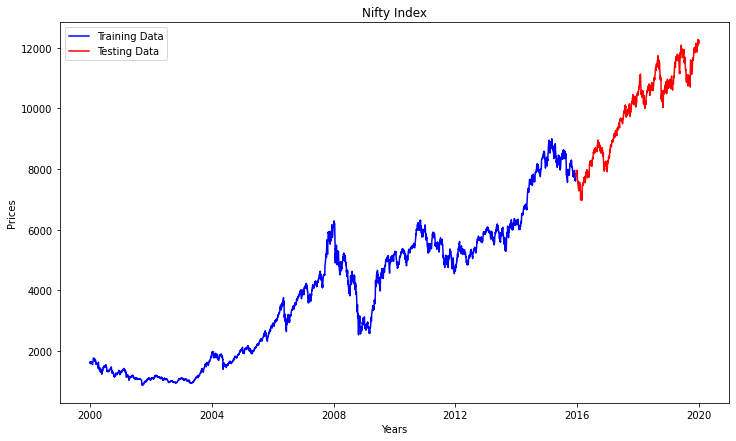

In [ ]:
#Splitting in 80:20 Ratio
train_data, test_data = nifty[0:int(len(nifty)*0.8)], nifty[int(len(nifty)*0.8):]

train_data = train_data.set_index('date', drop= False)
test_data = test_data.set_index('date', drop= False)

plt.figure(figsize=(12,7))
plt.title('Nifty Index')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.plot(train_data['price'], 'blue', label='Training Data')
plt.plot(test_data['price'], 'red', label='Testing Data')
plt.legend()

In [ ]:
print(f"Train Data Shape: {train_data.shape}")
print(f"Test Data Shape: {test_data.shape}")

Train Data Shape: (3977, 2)
Test Data Shape: (995, 2)


In [ ]:
train_data.to_csv('train.csv')
test_data.to_csv('test.csv')


#Exploratory Data Analysis

##News Data

In [ ]:
tweet_news.head()

,date,tweet_news_combined,score,sentiment
0,2015-01-01,tvs motor sales up in december central bank a...,0.8979,1.0
1,2015-01-02,ecb chief sees limited risk of deflation in eu...,0.9975,1.0
2,2015-01-03,establish banks which rank among the top banks...,0.9459,1.0
3,2015-01-04,norms tightened for appointment of agents by i...,0.9648,1.0
4,2015-01-05,indian start ups may create lakh jobs in years...,0.9818,1.0


In [ ]:
print(f"No. of rows: {tweet_news.shape[0]}")
print(f"No. of columns: {tweet_news.shape[1]}")

No. of rows: 1818
No. of columns: 4


###Checking for duplicate rows

In [ ]:
tweet_news.duplicated().sum()

0

There is no duplicate row present.

###Checking for Missing Values

In [ ]:
tweet_news.isna().sum()

date                   0
tweet_news_combined    0
score                  0
sentiment              0
dtype: int64

There is no missing value present.

Text(0.5, 1.0, 'Count Plot on Sentiment Variable')

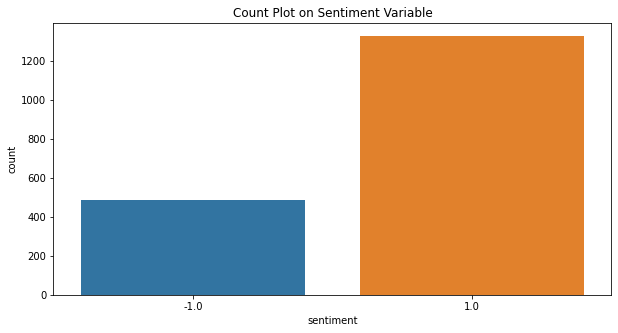

In [ ]:
plt.figure(figsize=(10, 5))
sns.countplot(tweet_news['sentiment'])
plt.title('Count Plot on Sentiment Variable')

In [ ]:
tweet_news['sentiment'].value_counts()

 1.0    1329
-1.0     489
Name: sentiment, dtype: int64

As expected, we can observe more number of positive news which reflects why nifty shows an upward trend overall. We have 37% negative tweets here. Results looking realistic so far.

Word Cloud for Positive Tweets


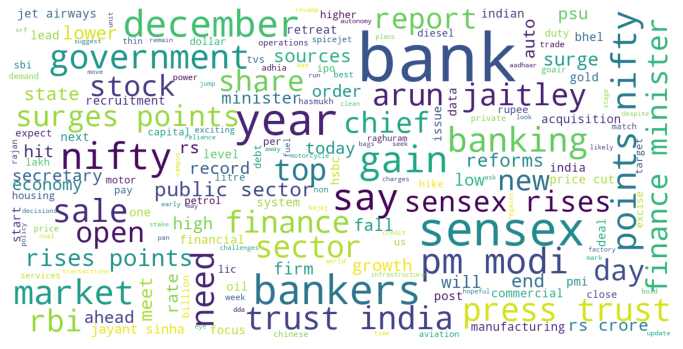


Word Cloud for Negative Tweets


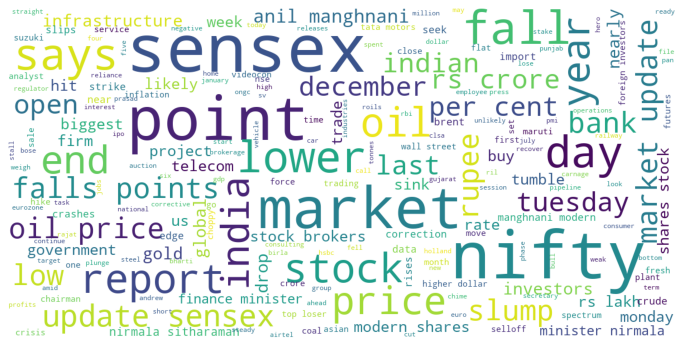

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200000,
        max_font_size=40,
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

print("Word Cloud for Positive Tweets")
show_wordcloud(tweet_news[tweet_news['sentiment'] == 1].values)
print("\nWord Cloud for Negative Tweets")
show_wordcloud(tweet_news[tweet_news['sentiment'] == -1].values)

We can observe that words like gain, top, rise, surge result in a positive tweet and words like lower, fall, hit, drop, slump result in a negative tweet. Looks like bank stocks are the most fluctuating ones.

###Probability Distribution of Sentiment Scores by VADER

Text(0.5, 1.0, 'Probability Distribution of Sentiment Scores by VADER')

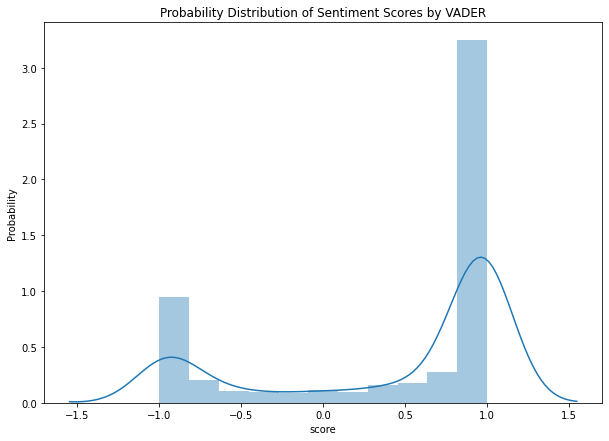

In [ ]:
plt.figure(figsize=(10, 7))
sns.distplot(tweet_news['score'])
plt.ylabel('Probability')
plt.title('Probability Distribution of Sentiment Scores by VADER')

For majority of news, VADER is confident in detecting either positive or negative sentiment since most of the points lie on the boundary. This shows accurate and confident prediction from VADER library.

###Date-wise Distribution of News Sentiments

In [ ]:
tweet_news.set_index('date', inplace = True)

In [ ]:
tweet_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1818 entries, 2015-01-01 to 2019-12-31
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   tweet_news_combined  1818 non-null   object 
 1   score                1818 non-null   float64
 2   sentiment            1818 non-null   float64
dtypes: float64(2), object(1)
memory usage: 56.8+ KB


In [ ]:
tweet_news.reset_index(inplace = True)

In [ ]:
tweet_news['date'] = pd.to_datetime(tweet_news['date'])
tweet_news['date'] = tweet_news['date'].dt.date
tweet_news.set_index('date', inplace = True)

Text(0, 0.5, 'Sentiment Scores')

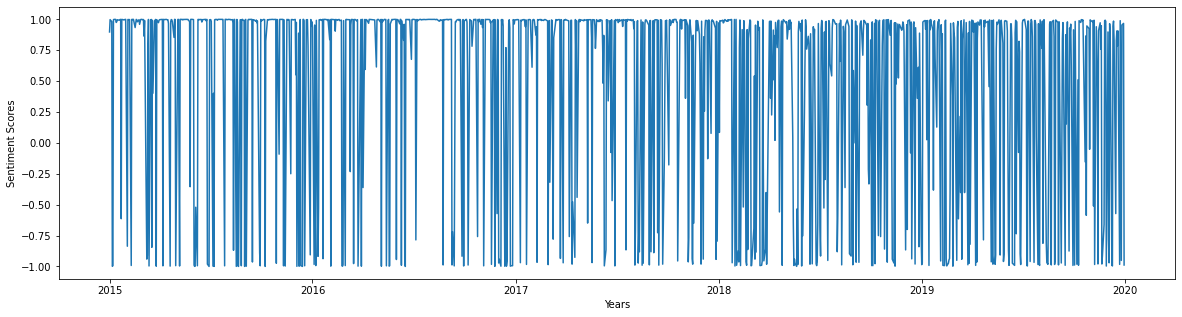

In [ ]:
import matplotlib

plt.figure(figsize=(20, 5))
plt.plot(tweet_news['score'])
plt.xlabel('Years')
plt.ylabel('Sentiment Scores')

##Nifty Index Data

This data contains nifty50 Index Price values for last 20 years.

In [ ]:
train_data.head()

,date,price
date,,
2000-01-03,2000-01-03,1592.2
2000-01-04,2000-01-04,1638.7
2000-01-05,2000-01-05,1595.8
2000-01-06,2000-01-06,1617.6
2000-01-07,2000-01-07,1613.3


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3977 entries, 2000-01-03 to 2015-12-16
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3977 non-null   datetime64[ns]
 1   price   3977 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 93.2 KB


We have got date column in datetime type and price in float type with no null values.

In [ ]:
print(f"No. of rows: {train_data.shape[0]}")
print(f"No. of columns: {train_data.shape[1]}")

No. of rows: 3977
No. of columns: 2


###Checking for duplicate rows

In [ ]:
train_data.duplicated().sum()

0

There is no duplicate row present.

###Checking for Missing Values

In [ ]:
train_data.isna().sum()

date     0
price    0
dtype: int64

There is no missing value present.

###Probability Distribution of Nifty index Closing Prices

Text(0.5, 1.0, 'Probability Distribution of Nifty Index Closing Prices')

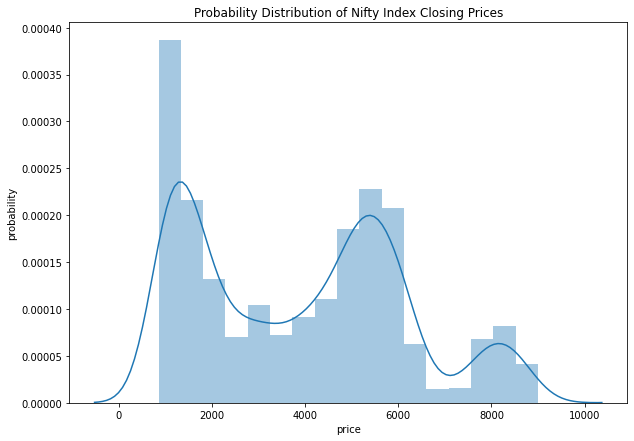

In [ ]:
plt.figure(figsize=(10, 7))
sns.distplot(train_data['price'])
plt.ylabel('probability')
plt.title('Probability Distribution of Nifty Index Closing Prices')

Nifty index price hovered over 1000 and 5000 levels for the most time in past 20 years. Our train data rarely went past 10000 levels.

##Stationarity of a Time Series

To determine whether a time series is stationary, we rely on three fundamental criteria. In order to categorize a time series as stationary, its statistical attributes, such as mean and variance, must remain consistent over time.

These are the three characteristics of a stationary time series:

1. Consistent mean
2. Consistent variance
3. Autocovariance that is independent of time, where autocovariance denotes the covariance between the time series and lagged versions of itself.

Before proceeding, let's visualize and assess the presence of seasonality and trend in our time series.

In [ ]:
train_data.head()

,date,price
date,,
2000-01-03,2000-01-03,1592.2
2000-01-04,2000-01-04,1638.7
2000-01-05,2000-01-05,1595.8
2000-01-06,2000-01-06,1617.6
2000-01-07,2000-01-07,1613.3


Text(0.5, 0, 'Years')

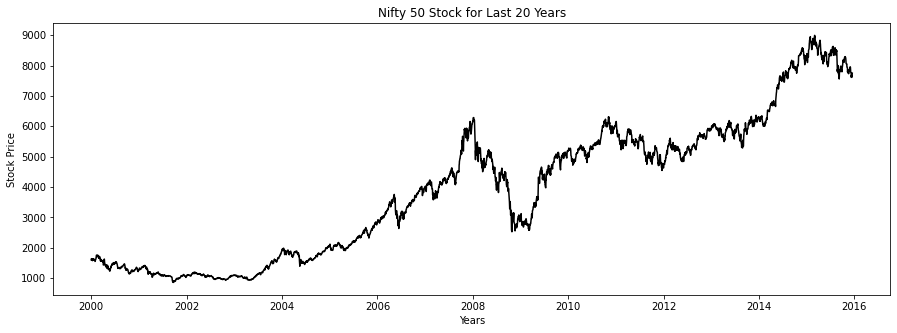

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(train_data.price, color='black')
plt.title("Nifty 50 Stock for Last 20 Years")
plt.ylabel("Stock Price")
plt.xlabel("Years")

**Trend**: This timeseries shows an upward trend.
This is a non-stationary time series. We need to convert it to stationary to forecast accurately.
Let's also check for the seasonality.

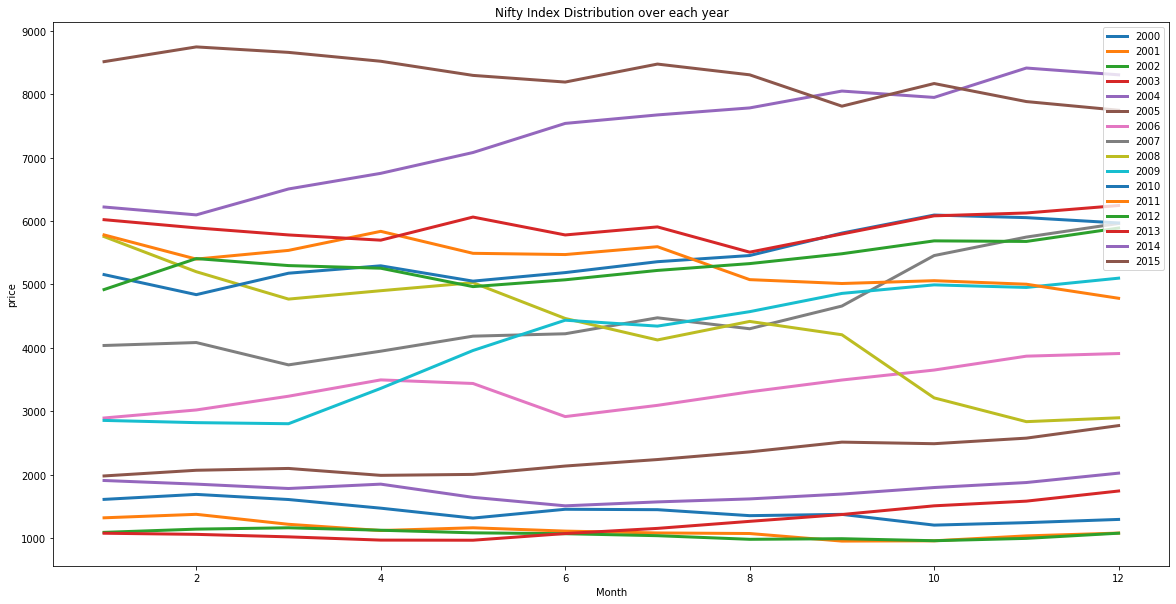

In [ ]:
season = train_data
season['Date'] = train_data.date
season['Year'] = train_data['date'].dt.year
season['Month'] = train_data['date'].dt.month
spivot = pd.pivot_table(season, index='Month', columns = 'Year', values = 'price')
spivot.plot(figsize=(20,10), linewidth=3)
plt.legend(loc = 'upper right')
plt.ylabel('price')
plt.title('Nifty Index Distribution over each year')
plt.show()

**Seasonality:** The time series exhibits a subtle seasonal pattern.

A noticeable price decrease becomes evident during the latter half of the year. Conversely, from January to June, we can discern a general upward trend. Consequently, the initial six months are generally considered a safer window for investment, with selling by June or July being a prudent strategy.

If a downward trend is observed during the first six months of the year, it is likely to persist into the following six months. In such cases, it is advisable to sell as soon as possible or consider holding the stock for a more extended duration.

Let's now assess the stationarity of the time series. We can examine stationarity through the following methods:

1. **Plotting Rolling Statistics:** By using a window, let's say a window size of 6, we calculate rolling mean and variance to evaluate stationarity.

2. **Dickey-Fuller Test:** The outcomes of this test include a Test Statistic and Critical Values for various confidence levels. If the test statistic is less than the critical value, we can conclude that the time series is stationary. Our null hypothesis posits that the time series is non-stationary, while the alternative hypothesis suggests that the time series is stationary.

In order for a time series to be deemed stationary, the p-value should be less than 5%, enabling us to reject the null hypothesis.

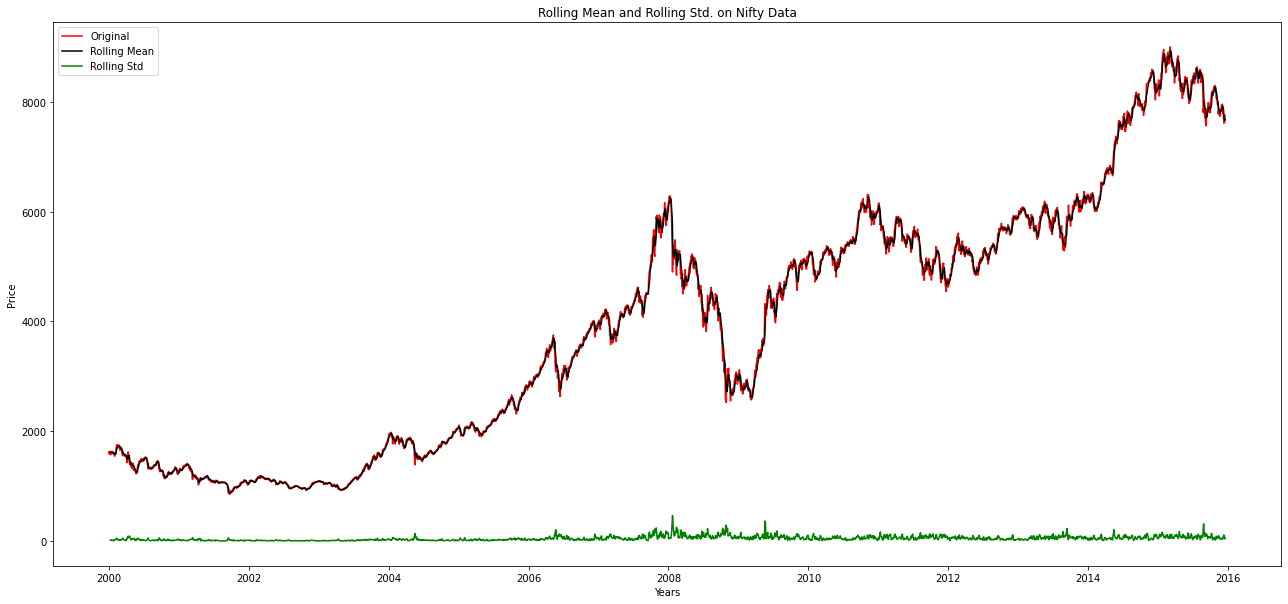

Test statistic:  -0.3721756097651497
p-value:  0.9146418268798999
Critical Values: {'1%': -3.4320015754188202, '5%': -2.862269775669594, '10%': -2.5671584676893895}


In [ ]:
#Reference: https://www.kaggle.com/kanncaa1/time-series-prediction-tutorial-with-eda

ts = train_data['price']
date = train_data['date']

# adfuller library
from statsmodels.tsa.stattools import adfuller

# check_adfuller
def check_adfuller(ts):

    # Dickey-Fuller test
    result = adfuller(ts, autolag='AIC')
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print('Critical Values:' ,result[4])

# check_mean_std
def check_mean_std(ts):

    #Rolling statistics
    rolmean = ts.rolling(6).mean()
    rolstd = ts.rolling(6).std()
    plt.figure(figsize=(22,10))
    orig = plt.plot(ts, color='red',label='Original')
    mean = plt.plot(rolmean, color='black', label='Rolling Mean')
    std = plt.plot(rolstd, color='green', label = 'Rolling Std')
    plt.xlabel("Years")
    plt.ylabel("Price")
    plt.title('Rolling Mean and Rolling Std. on Nifty Data')
    plt.legend()
    plt.show()

# check stationary: mean, variance(std) and adfuller test
check_mean_std(ts)
check_adfuller(ts)

Our initial criterion for stationarity pertains to a constant mean, and in this regard, we do not meet this criterion, as evident from the plot (represented by the black line).

The second criterion relates to a consistent variance, which appears to be met (as indicated by the green graph).

The third and final criterion involves the comparison of the test statistic with critical values to determine stationarity. In our case, the test statistic equals 0.674, while the critical values are {'1%': -3.431667761145687, '5%': -2.8621223070279247, '10%': -2.5670799628923104}. Since the test statistic exceeds the critical values, we conclude that the time series is not stationary.

As a result, we are sure that our time series is not stationary.
Lets make time series stationary at the next part.

We can do so with the help of two methods:

1.   Moving Average Method
2.   Differencing Method

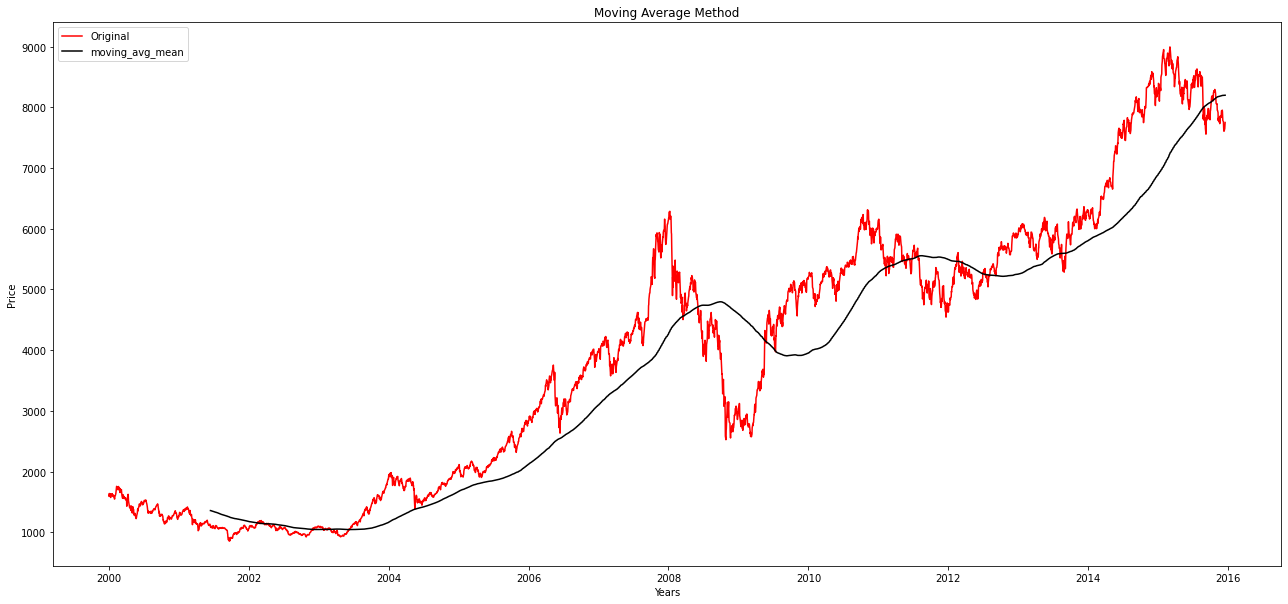

In [ ]:
# Moving average method
window_size = 365
moving_avg = ts.rolling(window_size).mean()
plt.figure(figsize=(22,10))
plt.plot(ts, color = "red",label = "Original")
plt.plot(moving_avg, color='black', label = "moving_avg_mean")
plt.title("Moving Average Method")
plt.xlabel("Years")
plt.ylabel("Price")
plt.legend()
plt.show()

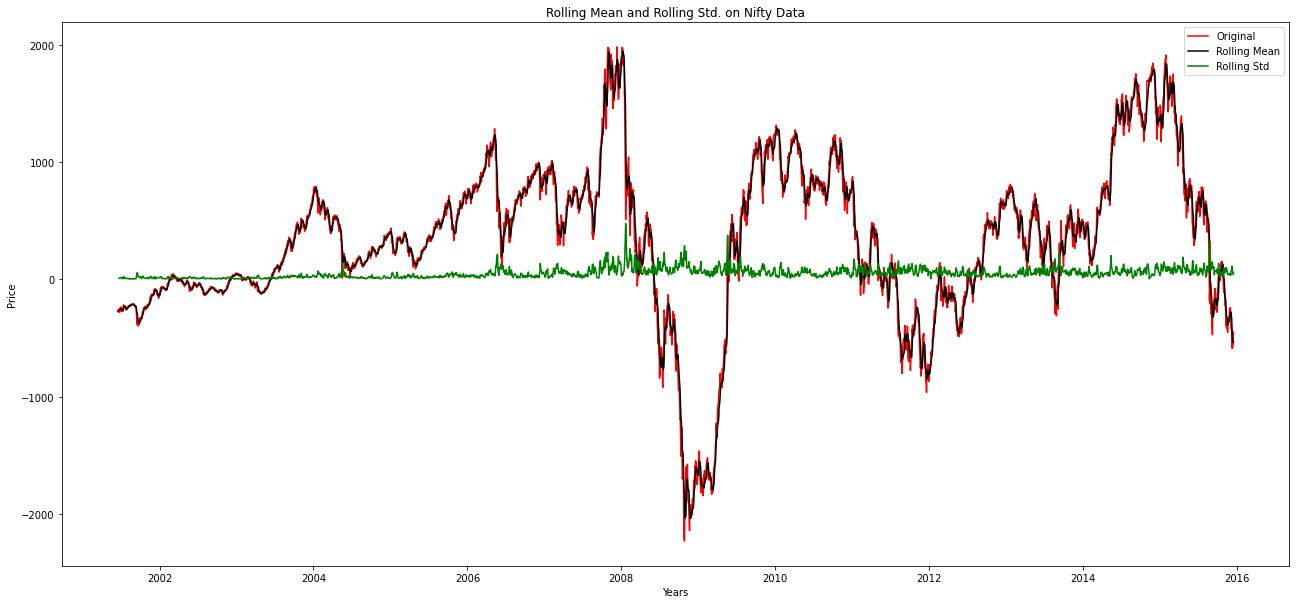

Test statistic:  -3.0585727512753724
p-value:  0.02977480324564729
Critical Values: {'1%': -3.432168780296152, '5%': -2.8623436353134553, '10%': -2.5671977878575616}


In [ ]:
ts_moving_avg_diff = ts - moving_avg
ts_moving_avg_diff.dropna(inplace=True) # first 3 is nan value due to window size

# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_moving_avg_diff)
check_adfuller(ts_moving_avg_diff)

The mean has stabilized over time, and no discernible trend is present. Furthermore, the p-value is less than 5%. However, it's crucial to note that the test statistic doesn't fall below the critical value, and the variance remains inconsistent.

Our time series has not achieved stationarity yet. Let's consider applying the differencing method as a next step.

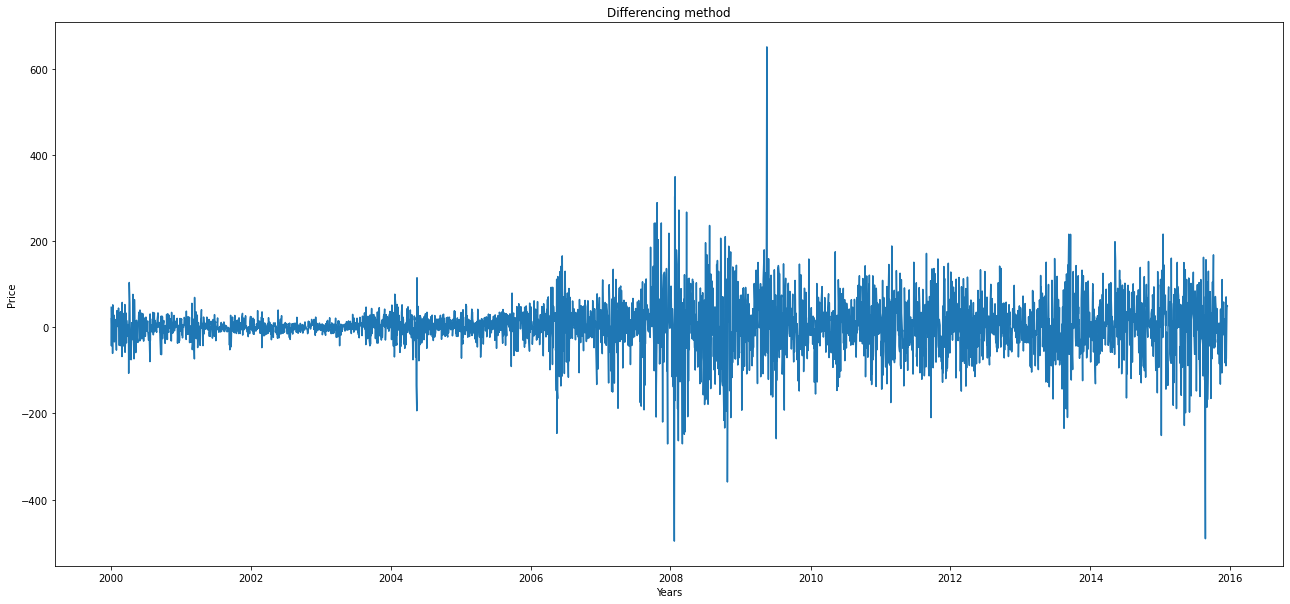

In [ ]:
# differencing method

#shifting by 1 period
ts_diff = ts - ts.shift(1)
plt.figure(figsize=(22,10))
plt.plot(ts_diff)
plt.title("Differencing method")
plt.xlabel("Years")
plt.ylabel("Price")
plt.show()

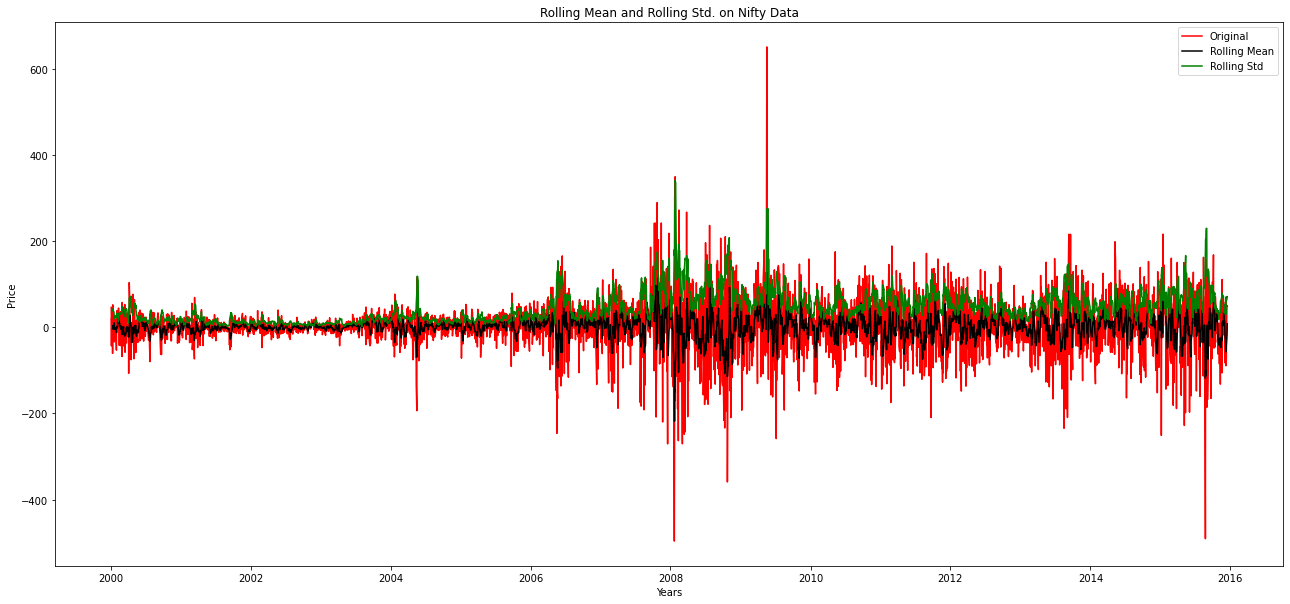

Test statistic:  -15.954568605066198
p-value:  7.292845706360018e-29
Critical Values: {'1%': -3.4320015754188202, '5%': -2.862269775669594, '10%': -2.5671584676893895}


In [ ]:
ts_diff.dropna(inplace=True) # due to shifting there is nan values
# check stationary: mean, variance(std)and adfuller test
check_mean_std(ts_diff)
check_adfuller(ts_diff)

The mean remains consistent over time with no discernible trend, supported by a p-value less than 5% and a test statistic below the critical value. However, it's important to note that the variance is not constant.

Excellent! Our time series is now close to being stationary. This stability allows us to employ this time series for forecasting, and it is likely to yield significant results.

#Modeling

The choice of ML models in this context is guided by the production demands, with the primary objective being model deployment. Given that time series models require regular retraining in a production setting to maintain prediction accuracy with incoming data points, we prioritize models with low time complexity in training. In other words, we focus on models that can quickly adapt to new data, ensuring efficient and timely updates.

##1. ARIMA

In [ ]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

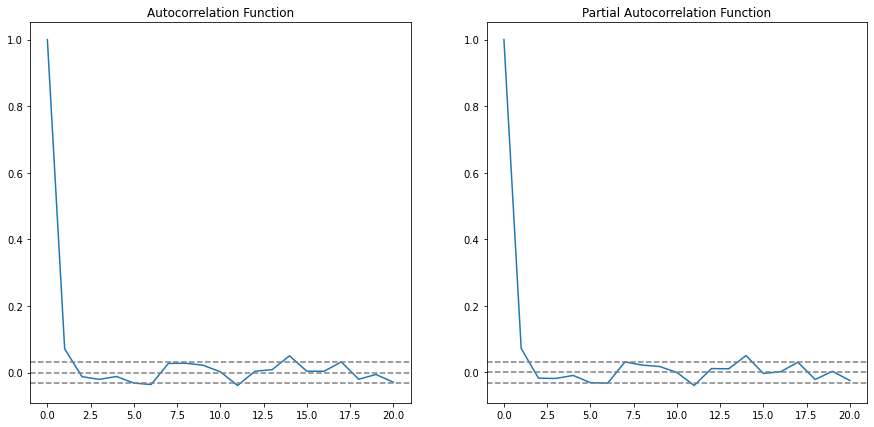

In [ ]:
plt.figure(figsize=(15,7))

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

p – The lag value where the PACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case p=2.


q – The lag value where the ACF chart crosses the upper confidence interval for the first time. If you notice closely, in this case q=2.


d - In differencing method, shift of 1 period produced a stationary timer series. So we will use d = 1.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                 3976
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -21871.592
Method:                       css-mle   S.D. of innovations             59.262
Date:                Thu, 06 Aug 2020   AIC                          43755.183
Time:                        10:22:50   BIC                          43792.911
Sample:                             1   HQIC                         43768.561
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             1.5496      0.986      1.571      0.116      -0.384       3.483
ar.L1.D.price    -0.5991      0.286     -2.094      0.036      -1.160      -0.038
ar.L2.D.price    -0.4093      0.227     

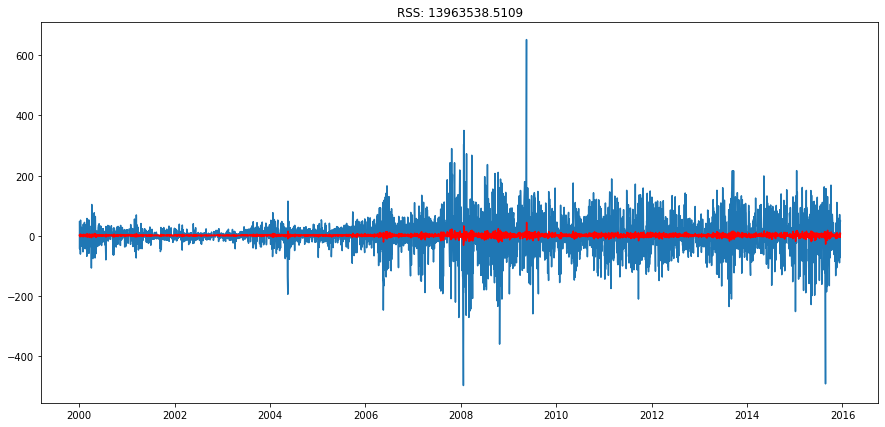

In [ ]:
plt.figure(figsize=(15,7))

model = ARIMA(ts, order=(2, 1, 2))
results_ARIMA = model.fit(disp=-1)
plt.plot(ts_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_diff)**2))

print(results_ARIMA.summary())

###Predicting Train Data

In [ ]:
yhat = results_ARIMA.predict(1, 3977)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
yhat.head()

0    1.549636
1    4.625111
2   -2.393849
3    2.953179
4    2.522729
dtype: float64

In [ ]:
predictions_ARIMA_diff_cumsum = yhat.cumsum() + train_data['price'][0]
print (predictions_ARIMA_diff_cumsum.head())
print (predictions_ARIMA_diff_cumsum.tail())

0    1593.749636
1    1598.374747
2    1595.980898
3    1598.934077
4    1601.456806
dtype: float64
3972    7747.790976
3973    7743.460032
3974    7745.907615
3975    7754.003662
3976    7755.619432
dtype: float64


Let's plot the final results from ARIMA

RMSE_ARIMA = 1062.8026556847378


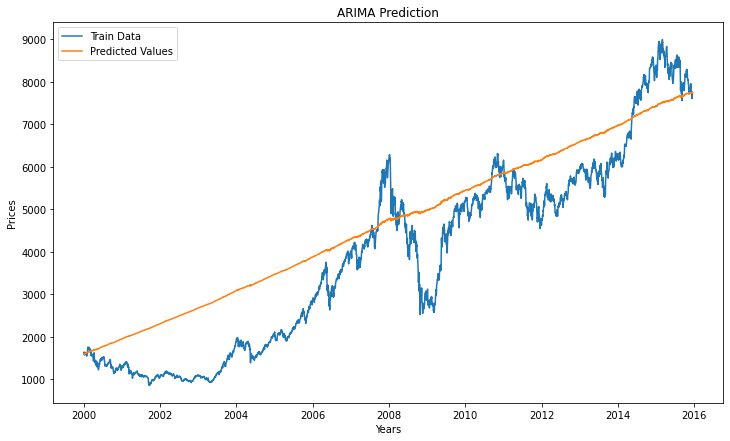

In [ ]:
#Predicting Train Data
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = pd.DataFrame(predictions_ARIMA_diff_cumsum.values)
predictions.set_index(train_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['price'], label = 'Train Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('ARIMA Prediction')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.legend()

RMSE_ARIMA = sqrt(mean_squared_error(train_data['price'].values, predictions_ARIMA_diff_cumsum.values))

print(f"RMSE_ARIMA = {RMSE_ARIMA}")

###ARIMA Forecasting

In [ ]:
len(train_data), len(test_data)

(3977, 995)

In [ ]:
yhat = results_ARIMA.predict(3977, 3977+994)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
yhat.head()

3976    1.615769
3977    0.067347
3978    2.410583
3979    1.640556
3980    1.142784
dtype: float64

In [ ]:
predictions_ARIMA_diff_cumsum = yhat.cumsum() + train_data['price'][-1]
print (predictions_ARIMA_diff_cumsum.head())
print (predictions_ARIMA_diff_cumsum.tail())

3976    7752.515769
3977    7752.583116
3978    7754.993699
3979    7756.634255
3980    7757.777039
dtype: float64
4966    9285.904064
4967    9287.453700
4968    9289.003336
4969    9290.552973
4970    9292.102609
dtype: float64


Let's plot the final results from ARIMA

RMSE_ARIMA = 1707.7770346921761


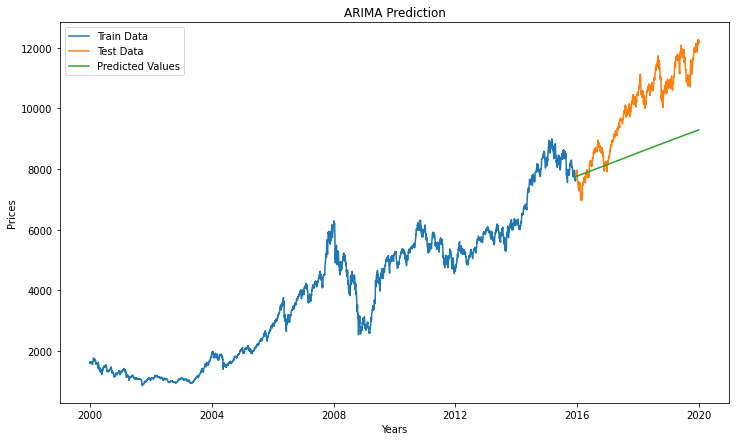

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

predictions = pd.DataFrame(predictions_ARIMA_diff_cumsum.values)
predictions.set_index(test_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['price'], label = 'Train Data')
plt.plot(test_data['price'], label = 'Test Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('ARIMA Prediction')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.legend()

RMSE_ARIMA = sqrt(mean_squared_error(test_data['price'].values, predictions_ARIMA_diff_cumsum.values))

print(f"RMSE_ARIMA = {RMSE_ARIMA}")

We have got RMSE: 1707 from ARIMA Model. Let's see if we can improve this.

##2. SARIMAX

The ARIMA Model exclusively takes into account trend information in the data while disregarding seasonal variations. SARIMAX, a derivative of the ARIMA Model, incorporates the seasonal aspects of the data as well. Even though our data doesn't exhibit pronounced seasonality, it's worth exploring to determine if it has any impact on improving the RMSE.

Let's experiment and assess whether it results in a reduction of RMSE.

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.tsa.statespace.SARIMAX(ts_diff, order=(2, 1, 2), seasonal_order=(1,1,1,12))
results_SARIMAX = model.fit()

print(results_SARIMAX.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                 Statespace Model Results                                 
Dep. Variable:                              price   No. Observations:                 3976
Model:             SARIMAX(2, 1, 2)x(1, 1, 1, 12)   Log Likelihood              -21842.127
Date:                            Thu, 06 Aug 2020   AIC                          43698.253
Time:                                    10:35:27   BIC                          43742.246
Sample:                                         0   HQIC                         43713.855
                                           - 3976                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9264      0.041    -22.504      0.000      -1.007      -0.846
ar.L2          0.0732      0.010   

###SARIMAX Forecasting

In [ ]:
len(train_data), len(test_data)

(3977, 995)

In [ ]:
yhat = results_SARIMAX.predict(3977, 3977+994)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [ ]:
yhat.head()

3977    -0.757555
3978    10.658790
3979     0.358834
3980     5.182702
3981     3.454101
dtype: float64

In [ ]:
predictions_SARIMAX_diff_cumsum = yhat.cumsum() + train_data['price'][-1]
print (predictions_SARIMAX_diff_cumsum.head())
print (predictions_SARIMAX_diff_cumsum.tail())

3977    7750.142445
3978    7760.801235
3979    7761.160068
3980    7766.342771
3981    7769.796872
dtype: float64
4967    10720.056774
4968    10722.499933
4969    10727.479500
4970    10728.938654
4971    10725.440970
dtype: float64


Let's plot the final results from SARIMAX

In [ ]:
yhat

3977    -0.757555
3978    10.658790
3979     0.358834
3980     5.182702
3981     3.454101
          ...    
4967     0.572148
4968     2.443159
4969     4.979568
4970     1.459153
4971    -3.497684
Length: 995, dtype: float64

RMSE_SARIMAX = 964.9740144692549


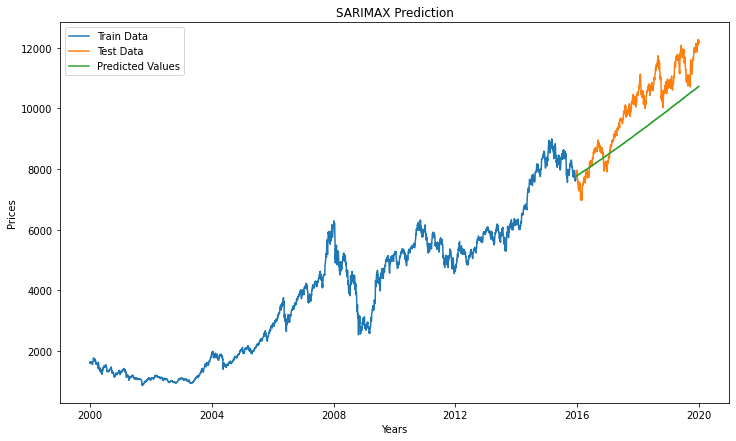

In [ ]:
predictions = pd.DataFrame(predictions_SARIMAX_diff_cumsum)
predictions.set_index(test_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['price'], label = 'Train Data')
plt.plot(test_data['price'], label = 'Test Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('SARIMAX Prediction')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.legend()

RMSE_SARIMAX = sqrt(mean_squared_error(test_data['price'].values, predictions_SARIMAX_diff_cumsum))

print(f"RMSE_SARIMAX = {RMSE_SARIMAX}")

Woah! RMSE got down to 964 from 1707. SARIMAX really works well.

##3. Facebook Prophet

In [ ]:
# Rename the features: These names are NEEDED for the model fitting
ts = train_data.rename(columns = {"date":"ds","price":"y"})

In [ ]:
from fbprophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(ts) # fit the model using all data

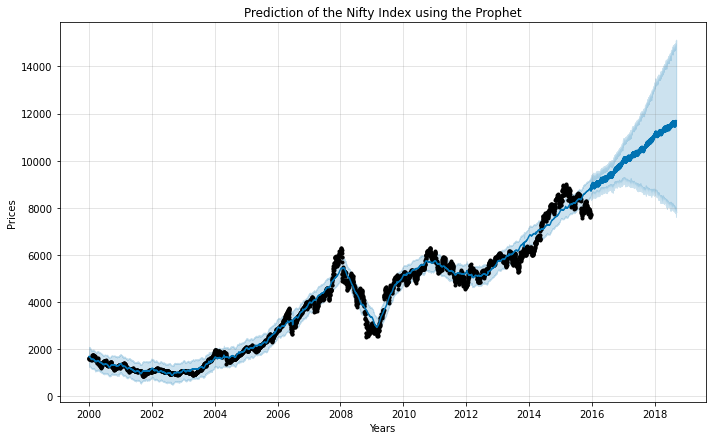

In [ ]:
future = m.make_future_dataframe(periods=994) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)

plt.title("Prediction of the Nifty Index using the Prophet")
plt.xlabel("Years")
plt.ylabel("Prices")
plt.show()

In [ ]:
yhat = prediction['yhat'].tail(995)

Elegant Plot. It shows the confidence interval as well. However, let's compare it with our test_data and find RMSE.

RMSE_Prophet = 709.7036520419836


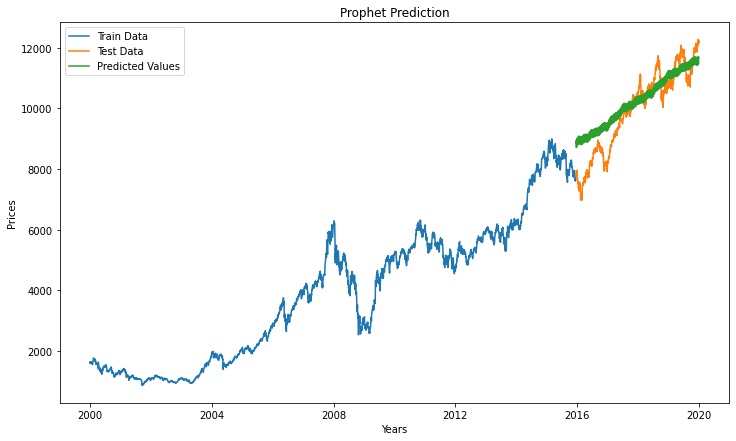

In [ ]:
predictions = pd.DataFrame(yhat)
predictions.set_index(test_data.index, inplace = True)

plt.figure(figsize=(12,7))

plt.plot(train_data['price'], label = 'Train Data')
plt.plot(test_data['price'], label = 'Test Data')
plt.plot(predictions, label = 'Predicted Values')
plt.title('Prophet Prediction')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.legend()

RMSE_Prophet = sqrt(mean_squared_error(test_data['price'].values, yhat))

print(f"RMSE_Prophet = {RMSE_Prophet}")

Nice! RMSE has futher reduced to 709 from 964. It is still far from acceptable prediction. Let's try deep learning models now.

###Plot the trend, weekly, seasonally, yearly and daily components

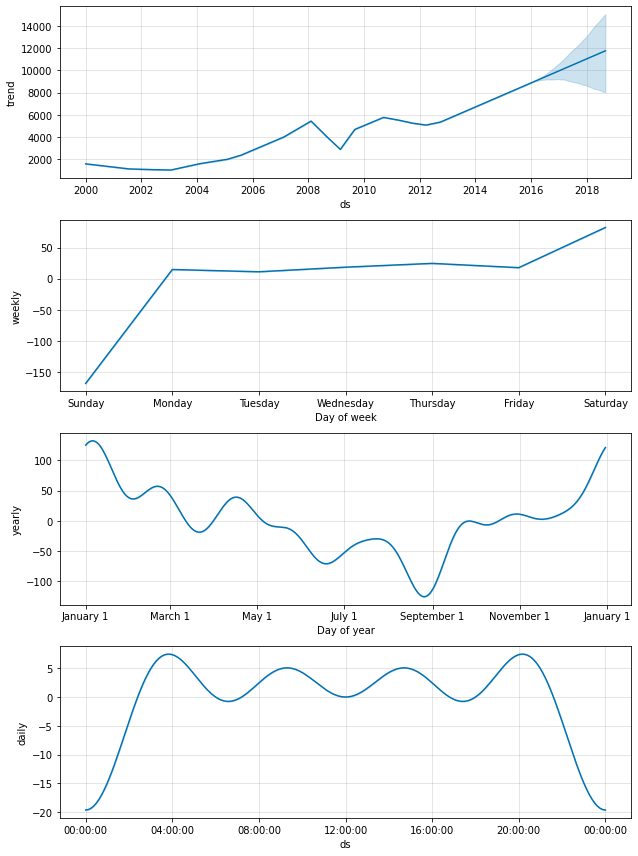

In [ ]:
m.plot_components(prediction)
plt.show()

Our dataset contains discernible seasonal patterns, which is why SARIMAX also yielded strong performance.

Key observations from the graphs above include:

1. Our data exhibits a clear upward trend.
2. Stock prices tend to rise on Saturdays and remain relatively stable during weekdays.
3. The period from late August to early September is often associated with a high likelihood of observing the lowest stock prices in a 52-week period.
4. Stock prices demonstrate fluctuations throughout the day.

##4. LSTM

In [ ]:
from tensorflow import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from tensorflow.keras import backend as K

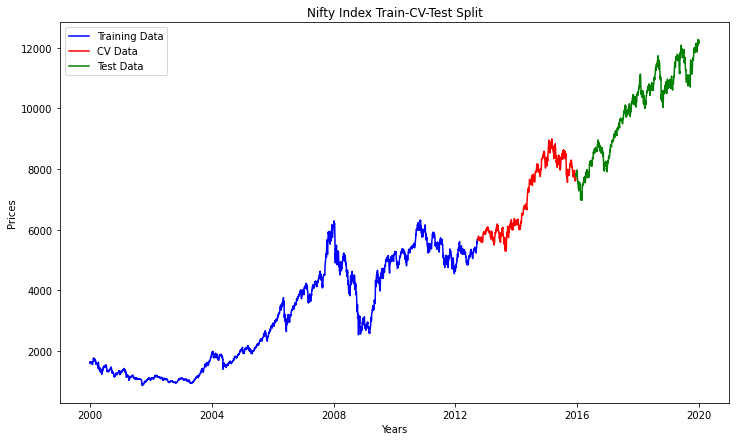

In [ ]:
#Splitting the data in Train-CV-Test in the ratio 64:16:20
X_train, X_cv = train_data[0:int(len(train_data)*0.8)], train_data[int(len(train_data)*0.8):]

X_train = X_train.set_index('date', drop= False)
X_cv = X_cv.set_index('date', drop= False)

plt.figure(figsize=(12,7))
plt.title('Nifty Index Train-CV-Test Split')
plt.xlabel('Years')
plt.ylabel('Prices')
plt.plot(X_train['price'], 'blue', label='Training Data')
plt.plot(X_cv['price'], 'red', label='CV Data')
plt.plot(test_data['price'], 'green', label='Test Data')
plt.legend()

In [ ]:
len(X_train)

3181

In [ ]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Feature Scaling
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(X_train['price'].values.reshape(-1, 1))
cv_set_scaled = sc.transform(X_cv['price'].values.reshape(-1, 1))
test_set_scaled = sc.transform(test_data['price'].values.reshape(-1, 1))

In [ ]:
#Creating Dataset with Window Size 30.

trainX, trainY = create_dataset(training_set_scaled, 30)
cvX, cvY = create_dataset(cv_set_scaled, 30)
testX, testY = create_dataset(test_set_scaled, 30)

In [ ]:
trainX.shape, cvX.shape, testX.shape

((3150, 30), (765, 30), (964, 30))

In [ ]:
#Reshaping all the data
trainX, trainY = np.array(trainX), np.array(trainY)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

cvX, cvY = np.array(cvX), np.array(cvY)
cvX = np.reshape(cvX, (cvX.shape[0], cvX.shape[1], 1))

testX, testY = np.array(testX), np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
#Defining our metric
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard

!rm -rf ./logs/
keras.backend.clear_session()
%load_ext tensorboard

model = Sequential()

# Adding the input layer
model.add(LSTM(units=48, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (X_train.shape[1], 1)))

# Adding the output layer
model.add(Dense(1, name="output_layer"))

# Compiling the RNN
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.001), loss = root_mean_squared_error)

#Using Tensorboard
logdir = "logs"
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=5, write_graph=True)

# Fitting the RNN to the Training set
model.fit(trainX, trainY, epochs = 50, batch_size = 16,  validation_data = (cvX, cvY), callbacks = [tensorboard_callback])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/50
197/197 [==============================] - 3s 14ms/step - loss: 0.0366 - val_loss: 0.0624
Epoch 2/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0198 - val_loss: 0.0315
Epoch 3/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0184 - val_loss: 0.0357
Epoch 4/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0168 - val_loss: 0.0228
Epoch 5/50
197/197 [==============================] - 2s 10ms/step - loss: 0.0165 - val_loss: 0.0236
Epoch 6/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0158 - val_loss: 0.0194
Epoch 7/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0151 - val_loss: 0.0182
Epoch 8/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0149 - val_loss: 0.0342
Epoch 9/50
197/197 [==============================] - 2s 11ms/step - loss: 0.0136 - val_loss: 0.0212
E

In [ ]:
#Predicting on test data
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
#Changing datatype of date column from string to datetime

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data['date'] = train_data['date'].dt.date
test_data['date'] = test_data['date'].dt.date

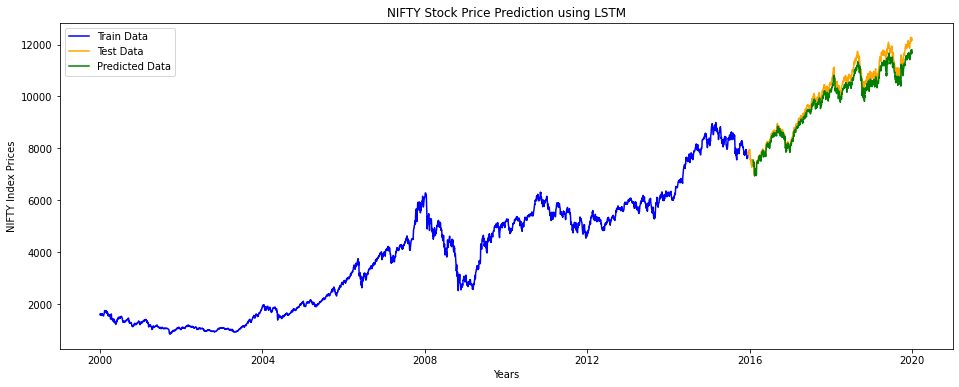

RMSE_LSTM = 285.5356095605939


In [ ]:
# Visualising the results
plt.figure(figsize=(16, 6))
plt.plot(train_data['date'], train_data['price'], color = 'blue', label = 'Train Data')
plt.plot(test_data['date'], test_data['price'].values, color = 'orange', label = 'Test Data')
plt.plot(test_data.iloc[31:]['date'], predicted_stock_price, color = 'green', label = 'Predicted Data')
plt.title('NIFTY Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('NIFTY Index Prices')
plt.legend()
plt.show()
from math import sqrt

RMSE_LSTM = sqrt(mean_squared_error(test_data.iloc[31:]['price'].values, predicted_stock_price))

print(f"RMSE_LSTM = {RMSE_LSTM}")

RMSE has gone down to 285 compared to 709 from Facebook Prophet Model. LSTM Model has predicted very accurately.
Let's try more advanced LSTM variations.

##5. LSTM with news polarity

We will be using only 5 years of stock data for this model. Since we have news available for only 5 years period 2015-2019.

In [ ]:
#Loading only 5 years of data
nifty_5yrs = nifty[nifty['date'] > '2014-12-31']

In [ ]:
nifty_5yrs = nifty_5yrs.reset_index(drop = True)

In [ ]:
nifty_5yrs.head()

,date,price
0,2015-01-01,8284.00
1,2015-01-02,8395.45
2,2015-01-05,8378.40
3,2015-01-06,8127.35
4,2015-01-07,8102.10


In [ ]:
tweet_news.reset_index(inplace = True)
tweet_news.set_index('date', inplace = True, drop = False)

In [ ]:
#Removing news for missing dates in stock price data. In Stock Price Data, data corresponding to weekend, public holidays are missing.

s = set([str(i).split('T')[0] for i in nifty_5yrs['date'].values])
n = set(list(tweet_news['date'].values))

common_dates_1 = list(n.symmetric_difference(s))

for i in tweet_news.itertuples():
    if i[1] not in [str(i).split('T')[0] for i in nifty_5yrs['date'].values]:
        tweet_news.drop(tweet_news[tweet_news['date'] == i[1]].index, inplace = True)
    else:
        pass

for j in common_dates_1:
    tweet_news.drop(tweet_news[tweet_news['date'] == j].index, inplace = True)
    nifty_5yrs.drop(nifty_5yrs[nifty_5yrs['date'] == j].index, inplace = True)

In [ ]:
tweet_news.shape

(1232, 5)

In [ ]:
nifty_5yrs.shape

(1232, 2)

In [ ]:
tweet_news.head()

,index,date,tweet_news_combined,score,sentiment
date,,,,,
2015-01-01,0,2015-01-01,tvs motor sales up in december central bank a...,0.8979,1.0
2015-01-02,1,2015-01-02,ecb chief sees limited risk of deflation in eu...,0.9975,1.0
2015-01-05,4,2015-01-05,indian start ups may create lakh jobs in years...,0.9818,1.0
2015-01-06,5,2015-01-06,godrej consumer acquires south africa is frika...,-0.9982,-1.0
2015-01-07,6,2015-01-07,telecom commission sends back g spectrum propo...,-0.9931,-1.0


In [ ]:
nifty_5yrs.head()

,date,price
0,2015-01-01,8284.00
1,2015-01-02,8395.45
2,2015-01-05,8378.40
3,2015-01-06,8127.35
4,2015-01-07,8102.10


In [ ]:
tweet_news['date'] = tweet_news['date'].astype(str)
nifty_5yrs['date'] = nifty_5yrs['date'].astype(str)

In [ ]:
tweet_news = tweet_news.drop('date', axis = 1)

In [ ]:
data1 = pd.merge(tweet_news, nifty_5yrs, on = 'date')

In [ ]:
data1.shape

(1232, 6)

In [ ]:
data1.head()

,date,index,tweet_news_combined,score,sentiment,price
0,2015-01-01,0,tvs motor sales up in december central bank a...,0.8979,1.0,8284.00
1,2015-01-02,1,ecb chief sees limited risk of deflation in eu...,0.9975,1.0,8395.45
2,2015-01-05,4,indian start ups may create lakh jobs in years...,0.9818,1.0,8378.40
3,2015-01-06,5,godrej consumer acquires south africa is frika...,-0.9982,-1.0,8127.35
4,2015-01-07,6,telecom commission sends back g spectrum propo...,-0.9931,-1.0,8102.10


In [ ]:
data = data1[['date', 'score', 'price']]

In [ ]:
#Splitting the 5 years stock data in Train-CV-Test in the ratio 64:16:20

train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]

train_data = train_data.set_index('date', drop= False)
test_data = test_data.set_index('date', drop= False)

In [ ]:
X_train, X_cv = train_data[0:int(len(train_data)*0.8)], train_data[int(len(train_data)*0.8):]

X_train = X_train.set_index('date', drop= False)
X_cv = X_cv.set_index('date', drop= False)

In [ ]:
len(X_train)

788

In [ ]:
len(X_cv), len(test_data)

(197, 247)

In [ ]:
def create_dataset(dataset, scoreset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		b = scoreset[i+look_back-1]
		dataX.append(np.append(a,b))
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# Feature Scaling
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(X_train['price'].values.reshape(-1, 1))
cv_set_scaled = sc.transform(X_cv['price'].values.reshape(-1, 1))
test_set_scaled = sc.transform(test_data['price'].values.reshape(-1, 1))

sc1 = MinMaxScaler()
training_score_scaled = sc1.fit_transform(X_train['score'].values.reshape(-1, 1))
cv_score_scaled = sc1.transform(X_cv['score'].values.reshape(-1, 1))
test_score_scaled = sc1.transform(test_data['score'].values.reshape(-1, 1))

In [ ]:
#Creating Dataset with window size = 60 + News Sentiment of Last Day

trainX, trainY = create_dataset(training_set_scaled, training_score_scaled, 60)
cvX, cvY = create_dataset(cv_set_scaled, cv_score_scaled, 60)
testX, testY = create_dataset(test_set_scaled, test_score_scaled, 60)

In [ ]:
trainX.shape, cvX.shape, testX.shape

((727, 61), (136, 61), (186, 61))

In [ ]:
#Reshaping all data.

trainX, trainY = np.array(trainX), np.array(trainY)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

cvX, cvY = np.array(cvX), np.array(cvY)
cvX = np.reshape(cvX, (cvX.shape[0], cvX.shape[1], 1))

testX, testY = np.array(testX), np.array(testY)
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard

!rm -rf ./logs/
keras.backend.clear_session()
%load_ext tensorboard

model = Sequential()

# Adding the input layer
model.add(LSTM(units=128, activation='tanh', kernel_initializer=tf.keras.initializers.glorot_uniform(seed=26), input_shape = (trainX.shape[1], 1), unroll = True))

# Adding the output layer
model.add(Dense(1, name="output_layer"))

# Compiling the RNN
model.compile(optimizer = keras.optimizers.Adam(learning_rate=0.01), loss = root_mean_squared_error)

#Using Tensorboard
logdir = "logs"
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=5, write_graph=True)

# Fitting the RNN to the Training set
model.fit(trainX, trainY, epochs = 30, batch_size = 64,  validation_data = (cvX, cvY), callbacks = [tensorboard_callback])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/30
 2/12 [====>.........................] - ETA: 3s - loss: 0.4291WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0769s vs `on_train_batch_end` time: 0.6827s). Check your callbacks.


12/12 [==============================] - 3s 224ms/step - loss: 0.2212 - val_loss: 0.2460
Epoch 2/30
12/12 [==============================] - 1s 72ms/step - loss: 0.0702 - val_loss: 0.1034
Epoch 3/30
12/12 [==============================] - 1s 74ms/step - loss: 0.0445 - val_loss: 0.0333
Epoch 4/30
12/12 [==============================] - 1s 73ms/step - loss: 0.0300 - val_loss: 0.0352
Epoch 5/30
12/12 [==============================] - 1s 73ms/step - loss: 0.0317 - val_loss: 0.0522
Epoch 6/30
12/12 [==============================] - 1s 74ms/step - loss: 0.0296 - val_loss: 0.0286
Epoch 7/30
12/12 [==============================] - 1s 74ms/step - loss: 0.0236 - val_loss: 0.0298
Epoch 8/30
12/12 [==============================] - 1s 73ms/step - loss: 0.0252 - val_loss: 0.0297
Epoch 9/30
12/12 [==============================] - 1s 73ms/step - loss: 0.0290 - val_loss: 0.0265
Epoch 10/30
12/12 [==============================] - 1s 73ms/step - loss: 0.0342 - val_loss: 0.0347
Epoch 11/30
12/12 [

In [ ]:
#Predicting on test data
predicted_stock_price = model.predict(testX)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
#Changing datatype of date column from string to datetime

train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data['date'] = train_data['date'].dt.date
test_data['date'] = test_data['date'].dt.date

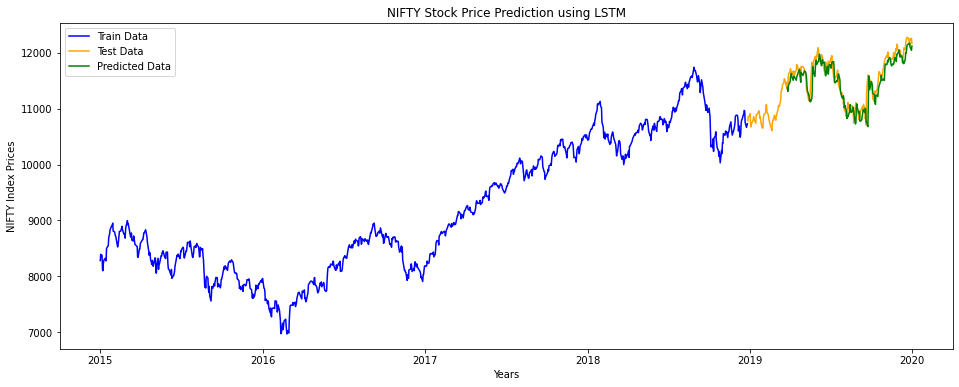

RMSE_LSTM = 170.90572686403854


In [ ]:
# Visualising the results
plt.figure(figsize=(16, 6))
plt.plot(train_data['date'], train_data['price'], color = 'blue', label = 'Train Data')
plt.plot(test_data['date'], test_data['price'].values, color = 'orange', label = 'Test Data')
plt.plot(test_data.iloc[61:]['date'], predicted_stock_price, color = 'green', label = 'Predicted Data')
plt.title('NIFTY Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('NIFTY Index Prices')
plt.legend()
plt.show()
from math import sqrt

RMSE_LSTM = sqrt(mean_squared_error(test_data.iloc[61:]['price'].values, predicted_stock_price))

print(f"RMSE_LSTM = {RMSE_LSTM}")

Wow! RMSE has further reduced to 170 from 285. News Sentiments has helped LSTM
to improve the prediction further.

This Model takes stock price data of last 60 days along with News Sentiment Compound Score from VADER for the last day and it will predict the stock price for next day.

##Summary

In [ ]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "RMSE on Test Data"]

x.add_row(["ARIMA", 1707.77])
x.add_row(["SARIMAX", 964.97])
x.add_row(["FB Prophet", 709.71])
x.add_row(["LSTM", 285.53])
x.add_row(["LSTM with News Sentiments", 170.91])

print(x)

+---------------------------+-------------------+
|           Model           | RMSE on Test Data |
+---------------------------+-------------------+
|           ARIMA           |      1707.77      |
|          SARIMAX          |       964.97      |
|         FB Prophet        |       709.71      |
|            LSTM           |       285.53      |
| LSTM with News Sentiments |       170.91      |
+---------------------------+-------------------+


##Best Model: LSTM with News Sentiments
##RMSE: 170.91

#Post-training quantization

We will here convert our best model to TensorFlow Lite Model. This reduces the size of the model as well as make the predictions faster but at a cost of accuracy. We will compare the performance of normal model as well as quantized model in the pipeline notebook.

###Converting Models into TFLite Models and Saving Them

For quantization: We will be converting Float32 weights into Float16 weights to make the prediction calculation faster.

In [ ]:
run_model = tf.function(lambda x: model(x))
BATCH_SIZE = 64
STEPS = None
INPUT_SIZE = 1
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))
MODEL_DIR = "./saved_model"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
#saving converted model in "converted_model.tflite" file
open("converted_model.tflite", "wb").write(tflite_model)

503684

In [ ]:
run_model = tf.function(lambda x: model(x))
BATCH_SIZE = 64
STEPS = None
INPUT_SIZE = 1
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model.inputs[0].dtype))
MODEL_DIR = "./saved_model"

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_quant_model = converter.convert()
#saving converted model in "converted_quant_model.tflite" file
open("converted_quant_model.tflite", "wb").write(tflite_quant_model)

463872

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


#Anamoly Detection

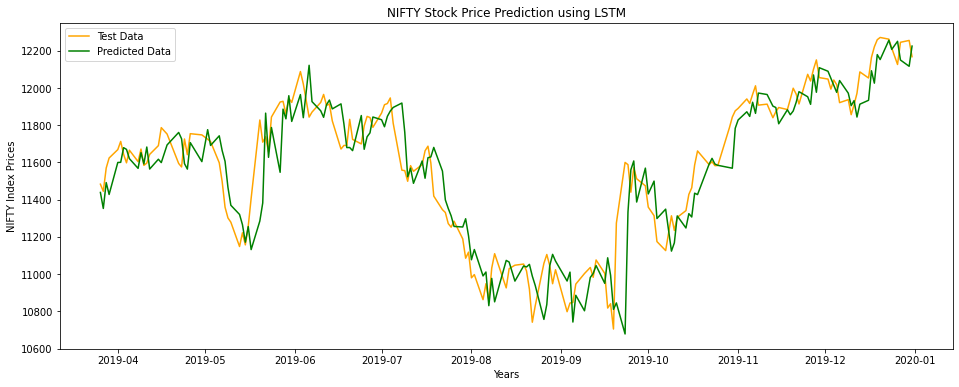

In [ ]:
# Visualising the results
plt.figure(figsize=(16, 6))
plt.plot(test_data[61:]['date'], test_data[61:]['price'].values, color = 'orange', label = 'Test Data')
plt.plot(test_data.iloc[61:]['date'], predicted_stock_price, color = 'green', label = 'Predicted Data')
plt.title('NIFTY Stock Price Prediction using LSTM')
plt.xlabel('Years')
plt.ylabel('NIFTY Index Prices')
plt.legend()
plt.show()

In [ ]:
#Calculating percentage error for each test point

errors = pd.DataFrame()

errors['actual_price'] = test_data[61:]['price'].values
errors['predicted_price'] = predicted_stock_price

errors.set_index(test_data[61:]['date'], inplace = True)

errors['error'] = (np.abs(errors['actual_price'] - errors['predicted_price']))/(errors['actual_price'])

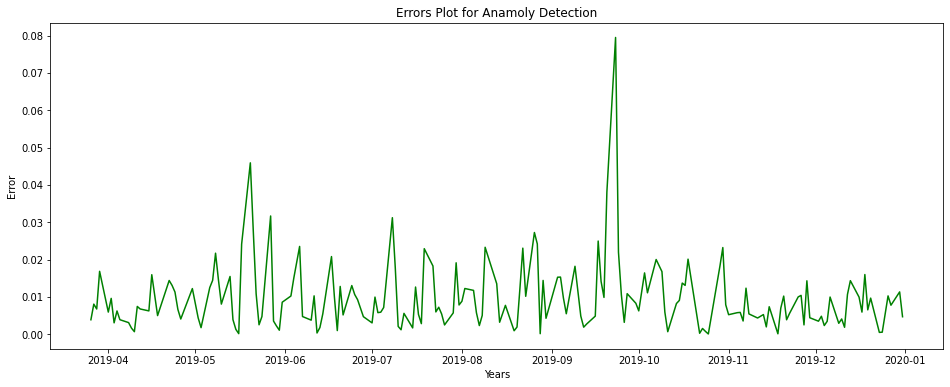

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(errors['error'], color = 'green')
plt.title('Errors Plot for Anamoly Detection')
plt.xlabel('Years')
plt.ylabel('Error')
plt.show()

In [ ]:
#Taking 4% error confidence interval

for i in errors.itertuples():
    if i[3] > 0.03:
        errors.at[i[0], 'anamoly'] = 1
    else:
        errors.at[i[0], 'anamoly'] = 0

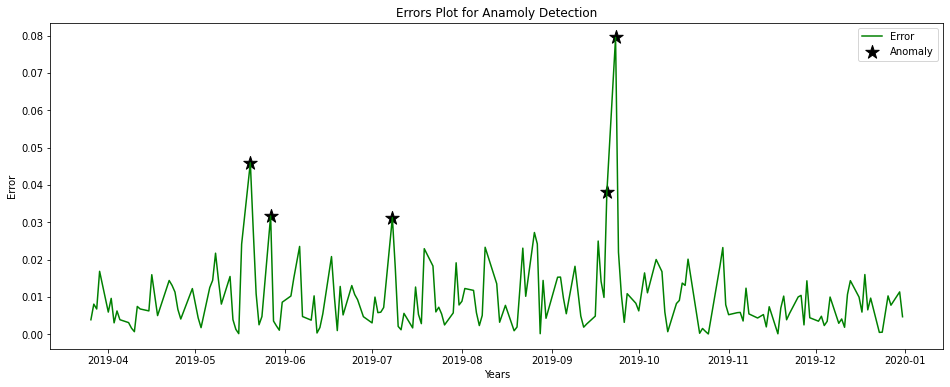

In [ ]:
plt.figure(figsize=(16, 6))

plt.plot(errors['error'], color = 'green', label = 'Error')
plt.scatter(y = errors[errors['anamoly'] == 1]['error'], x = errors[errors['anamoly'] == 1].index, marker='*', s = 200, color='black', label='Anomaly')
plt.title('Errors Plot for Anamoly Detection')
plt.xlabel('Years')
plt.ylabel('Error')
plt.legend()
plt.show()

In [ ]:
#Anamoly Dates
errors[errors['anamoly'] == 1].index

Index([2019-05-20, 2019-05-27, 2019-07-08, 2019-09-20, 2019-09-23], dtype='object', name='date')

In [ ]:
anamolies = data1[data1['date'].isin(['2019-05-20', '2019-05-27', '2019-07-08', '2019-09-20', '2019-09-23'])]

In [ ]:
anamolies.drop('index', axis = 1, inplace = True)
anamolies

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,date,tweet_news_combined,score,sentiment,price
1081,2019-05-20,tata motors sees jaguar land rover back in pro...,0.9961,1.0,11828.25
1086,2019-05-27,sensex rises over points nifty above mark ntpc...,0.8074,1.0,11924.75
1115,2019-07-08,budget clarification on surcharge for foreign ...,0.9169,1.0,11558.60
1165,2019-09-20,banks credit must grow to meet trillion econom...,0.9794,1.0,11274.20
1166,2019-09-23,august crude imports highest in months fuel im...,-0.8750,-1.0,11600.20


In [ ]:
anamolies['date'] = pd.to_datetime(anamolies['date'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


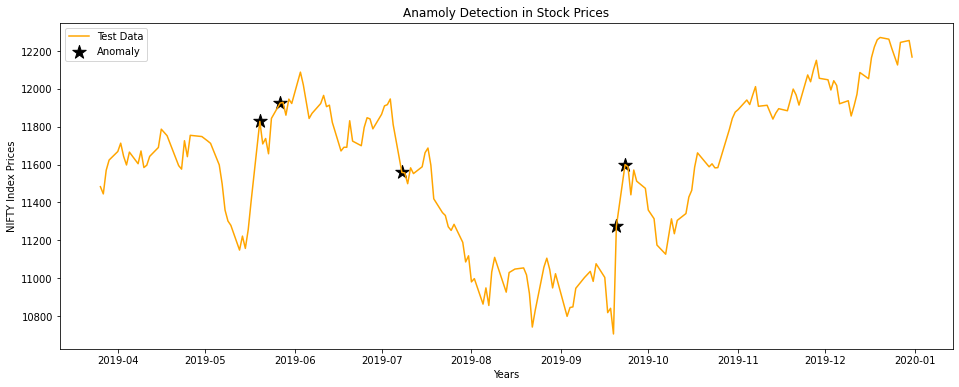

In [ ]:
# Visualising the results
plt.figure(figsize=(16, 6))
plt.plot(test_data[61:]['date'], test_data[61:]['price'].values, color = 'orange', label = 'Test Data')
plt.scatter(anamolies['date'], anamolies['price'], marker='*', s = 200, color='black', label='Anomaly')
plt.title('Anamoly Detection in Stock Prices')
plt.xlabel('Years')
plt.ylabel('NIFTY Index Prices')
plt.legend()
plt.show()

We can notice anomalies occurring when there is a sudden and significant increase or decrease in stock prices. These anomalies may be the result of major events that transpired on those particular days. Therefore, it would be beneficial to examine the tweets associated with days marked by such anomalies.

Word Cloud for Positive Tweets


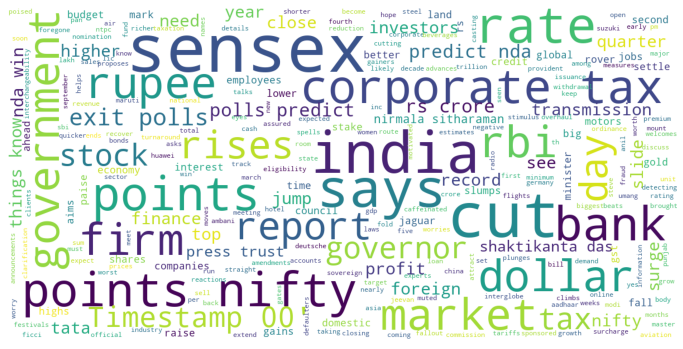


Word Cloud for Negative Tweets


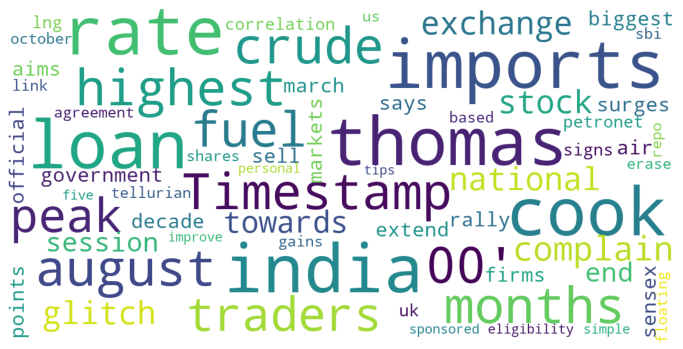

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200000,
        max_font_size=40,
        scale=3,
        random_state=1).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

print("Word Cloud for Positive Tweets")
show_wordcloud(anamolies[anamolies['sentiment'] == 1].values)
print("\nWord Cloud for Negative Tweets")
show_wordcloud(anamolies[anamolies['sentiment'] == -1].values)

It's evident that in positive tweets, the most frequently occurring word is 'cut,' which typically conveys a negative sentiment. Conversely, in negative tweets, words like 'highest,' 'biggest,' and 'peak,' all associated with positive sentiments, appear most frequently.

From this observation, it's apparent that the VADER Sentiment Analyzer didn't accurately assign sentiments to these tweets.

##Conclusion

In this project, we've gained valuable experience in managing and processing time series data, and we've developed deep learning models with a focus on real-world production applications. Notably, we've tackled the formidable task of working with stock price time series data and achieved a high level of accuracy in predicting the Nifty Index data.

However, the results can be improved further here using the following tips:
- Increase the timeframe for collecting news data to gather a greater number of data points.

-  Deep Learning Models perform exceptionally well when supplied with extensive data. Given our limited stock price dataset, a potential strategy to enhance stock analysis involves acquiring hourly stock price data instead of daily data, which would bolster our dataset and consequently improve accuracy.

- Enhance the model's accuracy by experimenting with different LSTM architecture configurations and adjusting hyperparameters.

- Rather than relying on a pre-trained VADER Sentiment Analyzer, consider developing a custom model by creating a training dataset tailored to the specific language used in stock market news. This custom-trained model is likely to yield superior sentiment analysis results.

- Recent research suggests that GANs and Reinforcement Learning can also be applied to enhance stock market prediction.

- To address anomalies more effectively, retrain the data with accurate sentiment scores using a custom-trained sentiment analyzer.

- To achieve even faster predictions, quantize the model to int8, but be aware that this may come at the cost of reduced accuracy.